In [1]:
import pandas as pd
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from typing import List, Callable
from scipy import stats
import timeit
import copy
import os
import Hawkes as hk
from datetime import datetime as dt
import warnings
import collections.abc
from tqdm import tqdm
import os.path as osp
import csv  

In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
register_matplotlib_converters()
sns.set()
warnings.filterwarnings("ignore")

## 1. Sanity check


### 1.1 First we implement the described algorithm
To do so we first implement the bis and ask prices

In [4]:
def bid_price(X):
    return(
        np.max(np.where(X < 0, np.arange(X.shape[0]), 0))
    )

def ask_price(X):
    return(
        np.min(np.where(X > 0, np.arange(X.shape[0]), X.shape[0]))
    )

Now we write functions to set the active windows given the window width K:

In [5]:
def ask_window(b_price, K, N):
    temp = b_price + np.arange(1,K+1)
    return(
        temp[temp<N]
    )

def bid_window(a_price, K):
    temp = a_price - np.flip(np.arange(1,K+1))
    return(
        temp[temp>=0]
    )

In [6]:
def simulate_OB(N, K, mu, lambda_, theta, X_0, T, file_path = "test_OB.csv"):
    t = 0
    X = X_0.copy()
    LOB = X_0.reshape((1,X_0.shape[0]))
    
        ##create the csv file 
    fields= ['ts','type','side','level','bid price','ask price']
    fields = fields + [f'bid {i}' for i in range(K)] + [f'ask {i}' for i in range(K)] 
    with open(file_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(fields)
    
    b_price = bid_price(X)
    a_price = ask_price(X)
    #print(X[490:510])
    
    A_window, B_window = ask_window(b_price, K, N), bid_window(a_price, K)
    LAMBDA = [mu, mu, K * lambda_, K * lambda_, theta * np.sum(np.abs(X[B_window])), theta * np.sum(np.abs(X[A_window]))]

    delta = stats.expon.rvs(scale = 1/np.sum(np.abs(LAMBDA)))
    event_type = np.random.choice( np.arange(6), p = np.array(LAMBDA)/np.sum(LAMBDA))
    
    with open(file_path, 'a') as f:
        while t<T:
            

            #print(X[B_window], b_price,event_type)
            if event_type == 0:
                ## bid market order
                type = 0 # market =0
                side = 0 # bid = 0
                level = 1 # level = 1
                X[a_price] = X[a_price] -  1

            elif event_type ==1:
                ### ask market order
                type = 0 # market 
                side = 1 # ask
                level = 1 # level = 1
                X[b_price]  = X[b_price] + 1

            elif event_type == 2:
                ## bid limit order
                type = 1 # limit order
                side = 0 # bid

                order_price = np.random.choice(B_window) # choose a price uniformly in the bid window
                level =   a_price - order_price +1
                X[order_price] = X[order_price] - 1 

            elif event_type == 3:
                ## ask limit order
                type = 1 # limit order
                side = 1 # ask side
                order_price = np.random.choice(A_window) #chose an order uniformly in the ask window
                level =  order_price - b_price + 1 # 
                X[order_price] =  X[order_price] + 1 

            elif event_type == 4:
                ## bid cancellation
                type = 2 #cancellation
                side = 0 # bid
                cancelation_price = np.random.choice(B_window, p = X[B_window]/np.sum(X[B_window])) #chose a cancellation in the window proportional to the size
                level =   b_price -cancelation_price +1 # 
                X[cancelation_price]  = X[cancelation_price] + 1 # cancel the bid for quantity 1

            elif event_type == 5:
                ## ask cancellation
                type = 2 # cancellation
                side = 1 # ask 
                cancelation_price = np.random.choice(A_window, p = X[A_window]/np.sum(X[A_window]))
                level =  cancelation_price - a_price   +1
                X[cancelation_price] = X[cancelation_price] - 1
            LOB = np.concatenate([LOB, X.reshape((1,X.shape[0]))],axis = 0)
            

            b_price = bid_price(X)
            a_price = ask_price(X)
            #print(X[490:510])
            
            A_window, B_window = ask_window(b_price, K, N), bid_window(a_price, K)
            LAMBDA = [mu, mu, K * lambda_, K * lambda_, theta * np.sum(np.abs(X[B_window])), theta * np.sum(np.abs(X[A_window]))]

            
            fields=[t, type ,side ,level,b_price,a_price]
            fields = fields + list(np.pad(X[B_window], pad_width=(K-B_window.shape[0],0))) + list(np.pad(X[A_window], pad_width=(0,K-A_window.shape[0])))

            delta = stats.expon.rvs(scale = 1/np.sum(np.abs(LAMBDA)))

            event_type = np.random.choice( np.arange(6), p = np.array(LAMBDA)/np.sum(LAMBDA))
            t += delta
            writer = csv.writer(f)
            writer.writerow(fields)

    return(LOB)

In [7]:
N= 1000
K = 10
mu = 2.5
lambda_ = 1
theta =   0.02
X_0 = np.zeros(N)
X_0[:(N//2)] = -5
X_0[(N//2):] = 5
T = 200

Test_OB = simulate_OB(N, K, mu, lambda_, theta, X_0, T)
pd.read_csv('test_OB.csv')

,ts,type,side,level,bid price,ask price,bid 0,bid 1,bid 2,bid 3,...,ask 0,ask 1,ask 2,ask 3,ask 4,ask 5,ask 6,ask 7,ask 8,ask 9
0,0.000000,1,1,5,499,500,-5.0,-5.0,-5.0,-5.0,...,5.0,5.0,5.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0
1,0.013073,0,0,1,499,500,-5.0,-5.0,-5.0,-5.0,...,4.0,5.0,5.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0
2,0.029937,1,1,9,499,500,-5.0,-5.0,-5.0,-5.0,...,4.0,5.0,5.0,6.0,5.0,5.0,5.0,6.0,5.0,5.0
3,0.052364,0,1,1,499,500,-5.0,-5.0,-5.0,-5.0,...,4.0,5.0,5.0,6.0,5.0,5.0,5.0,6.0,5.0,5.0
4,0.064753,1,1,7,499,500,-5.0,-5.0,-5.0,-5.0,...,4.0,5.0,5.0,6.0,5.0,6.0,5.0,6.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7235,199.860784,0,0,1,499,501,-49.0,-50.0,-47.0,-49.0,...,0.0,1.0,45.0,42.0,48.0,59.0,54.0,46.0,32.0,47.0
7236,199.870283,2,0,6,499,501,-49.0,-50.0,-47.0,-48.0,...,0.0,1.0,45.0,42.0,48.0,59.0,54.0,46.0,32.0,47.0
7237,199.877055,1,1,4,499,501,-49.0,-50.0,-47.0,-48.0,...,0.0,1.0,46.0,42.0,48.0,59.0,54.0,46.0,32.0,47.0
7238,199.927057,1,0,10,499,501,-49.0,-51.0,-47.0,-48.0,...,0.0,1.0,46.0,42.0,48.0,59.0,54.0,46.0,32.0,47.0


We can clearly see the orders are correctly proceeded and that bid and ask prices stay reasonable. Both stay positive and bid and ask move when the orders for a certain price become zero.

In [8]:
OB = pd.read_csv('test_OB.csv')

# number of bid market orders
nb_market_bids = ((OB["type"]==0) & (OB["side"]==0)).sum()
## we estimate the intensity of bid market orders
nb_market_bids/T

2.59

In [9]:
# number of ask market orders
nb_market_asks = ((OB["type"]==0) & (OB["side"]==1)).sum()
## we estimate the intensity of ask market orders
nb_market_asks/T

2.585

In [10]:
# number of bid limit orders
nb_limit_bids = ((OB["type"]==1) & (OB["side"]==0)).sum()
## we estimate the intensity of bid limit orders
intensity_times_K = nb_limit_bids/T
intensity_times_K/K

0.9970000000000001

In [11]:
# number of ask limit orders
nb_limit_asks = ((OB["type"]==1) & (OB["side"]==1)).sum()
## we estimate the intensity of ask limit orders
intensity_times_K = nb_limit_bids/T
intensity_times_K/K

0.9970000000000001

We can note that the intensities correspond to the ones we were expecting, e.g we get the intensity for limit and market orders we gave as input for the simulation.

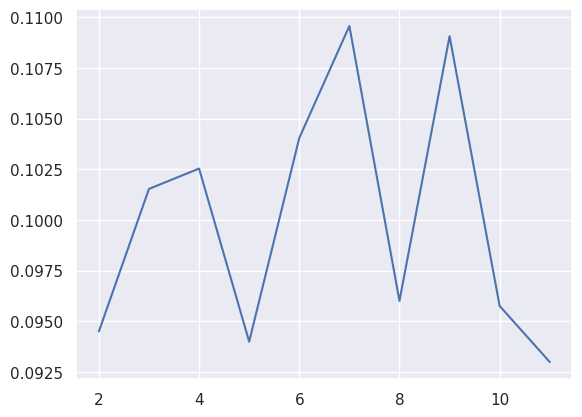

In [12]:
# positions of ask
nb_orders_per_level = OB.loc[(OB["type"]==1) & (OB["level"]!=1)].groupby(['level']).count()
## we estimate the intensity of bid limit orders
proportions_per_level = (nb_orders_per_level.iloc[:,0]/nb_orders_per_level.iloc[:,0].sum())
plt.plot(proportions_per_level.index,proportions_per_level)
plt.show()

We note that the proportion of event in each level of the limit order window is compatible with a uniform distribution (approximately 1/10 for each level from 2 to K+1)

## 2. Main analysis

### 2.1
We plot the mean shape of the limit order book simulated . For this we use the test limit order book and apply the mean by price: For visualisation purposes we only plot the active region of the order book

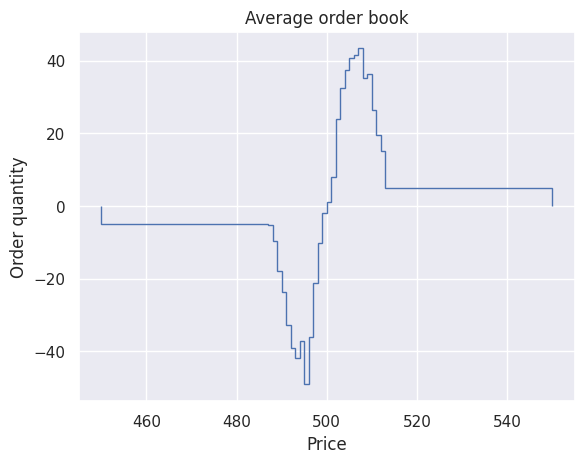

In [14]:
mean_ob = Test_OB.mean(axis =0)
plt.stairs(mean_ob[450:550],np.arange(450,551))
plt.title('Average order book')
plt.xlabel('Price')
plt.ylabel('Order quantity')
plt.show()

In [15]:
for i in range(450, 550):
    if mean_ob[i-1] < 0 and mean_ob[i] >= 0:
        change = i
        break
change

500

In [16]:
tick_size = 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


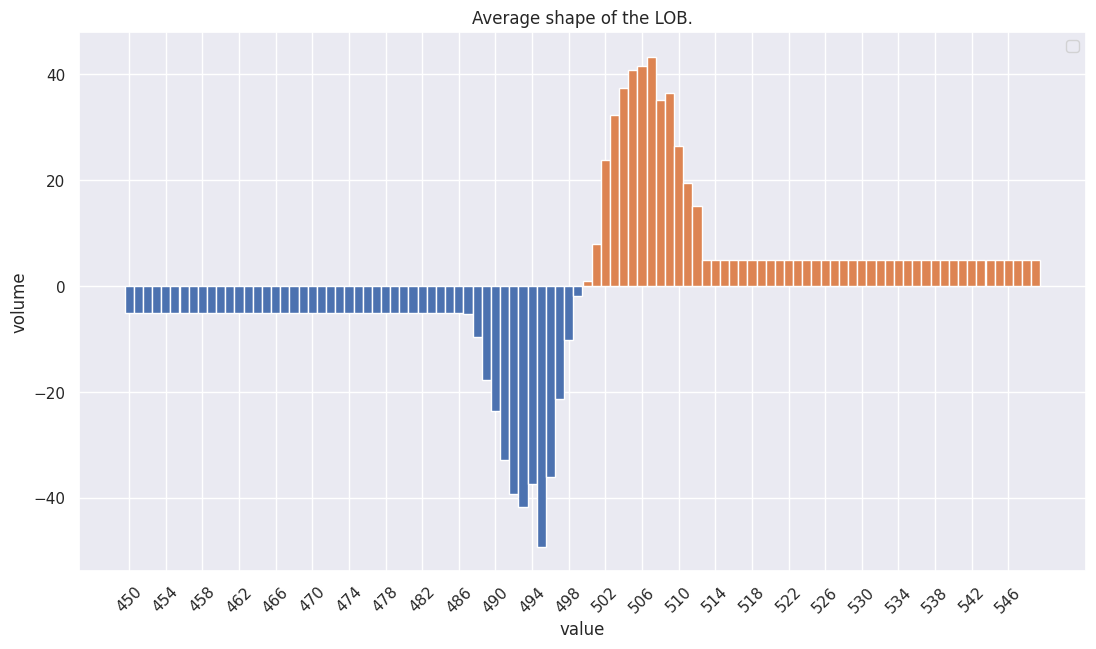

In [17]:
fig, ax = plt.subplots(figsize=(13, 7))
ax.bar(x = np.arange(450,change), 
        height = mean_ob[450:change],
        width = tick_size)
ax.bar(x = np.arange(change,550), 
        height =  mean_ob[change:550],
        width = tick_size)
ax.set_title('Average shape of the LOB.')
ax.set_ylabel('volume')
ax.set_xlabel('value')
ax.xaxis.set_tick_params(rotation=45)
ax.set_xticks(np.arange(450,550, 4))
ax.grid(True)
ax.legend()

The shape of the LOB seems good since we have maximas of ask and bid away from best prices and a hump shaped OB.

### 2.2
We plot the spread distribution, we see that the tick is rather stable arounf two and one which indicates we are probably simulating here a market where the tick is relatively large for the intensity of market and limit order.

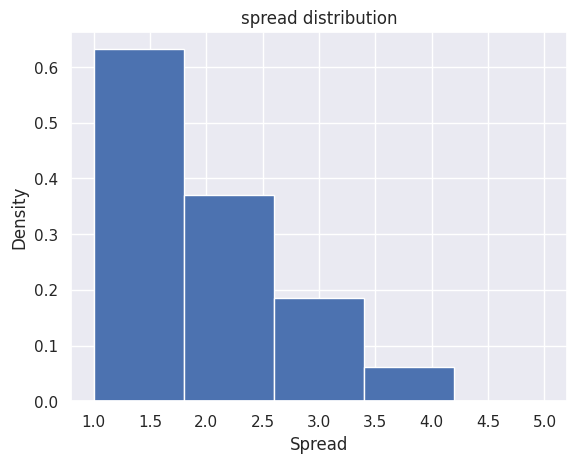

In [18]:
spread = OB['ask price'] - OB['bid price']
spread.hist(density = True, bins = 5)
plt.xlabel("Spread")
plt.ylabel("Density")
plt.title( "spread distribution")
plt.show()

### 2.3.
We plot the mid price variation in out LOB.

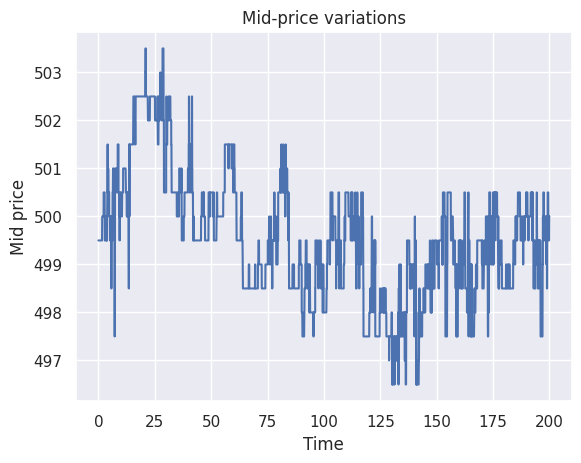

In [20]:
mid_price = (OB["ask price"] + OB["bid price"])/2
plt.plot(OB['ts'],mid_price)
plt.xlabel('Time')
plt.ylabel('Mid price')
plt.title('Mid-price variations')
plt.show()

At a large scale:

In [21]:
n_steps = 300

In [22]:
mid_price_variations = mid_price#.pct_change().dropna()

In [23]:
large_scale_mid_price_variations = [mid_price_variations[n_steps * i:n_steps*(i+1)].mean() for i in range(int(mid_price.shape[0] / n_steps))]

In [24]:
x_axis = [OB['ts'][i * n_steps / 2] for i in range(int(mid_price.shape[0] / n_steps))]

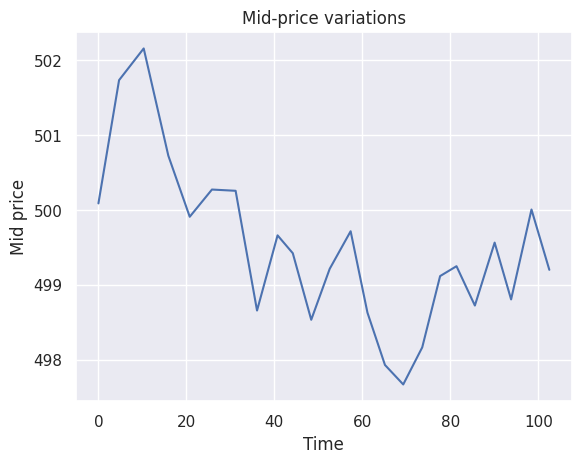

In [25]:
plt.plot(x_axis,large_scale_mid_price_variations)
plt.xlabel('Time')
plt.ylabel('Mid price')
plt.title('Mid-price variations')
plt.show()

### 2.4.
We plot the distribution of the mid price increment for several sampling periods,

In [26]:
OB_copy = OB.set_index('ts').copy()


In [27]:
OB_copy.index = pd.to_timedelta(OB_copy.index,'s')


In [28]:
OB_second= OB_copy.resample('1S',convention='end').apply(lambda x : x.iloc[-1])


In [29]:
OB_half_second= OB_copy.resample(pd.Timedelta(seconds=1/2),convention='end').apply(lambda x : x.iloc[-1])


In [30]:
OB_quarter_second= OB_copy.resample(pd.Timedelta(seconds=1/4),convention='end').apply(lambda x : x.iloc[-1])


In [31]:
OB_second['mid_price']= (OB_second['ask price']+ OB_second['bid price'])/2

In [32]:
OB_half_second['mid_price']= (OB_half_second['ask price']+ OB_half_second['bid price'])/2

In [33]:
OB_quarter_second['mid_price']= (OB_quarter_second['ask price']+ OB_quarter_second['bid price'])/2


<AxesSubplot: >

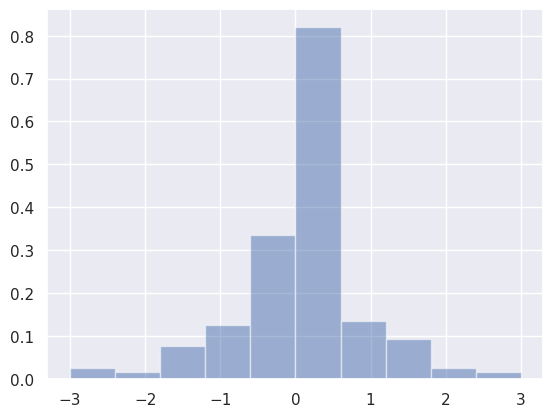

In [34]:
OB_second['mid_price'].diff().hist(density = True,alpha = 0.5)

<AxesSubplot: >

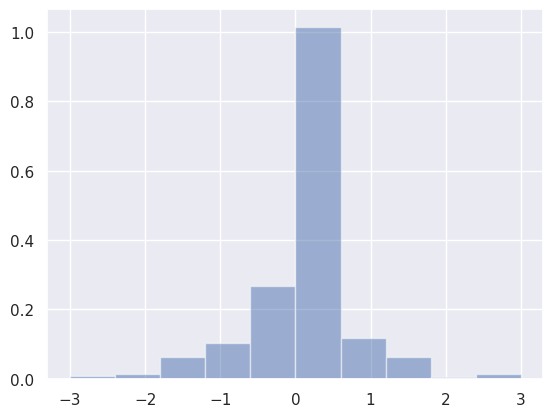

In [35]:
OB_half_second['mid_price'].diff().hist(density = True,alpha = 0.5)


<AxesSubplot: >

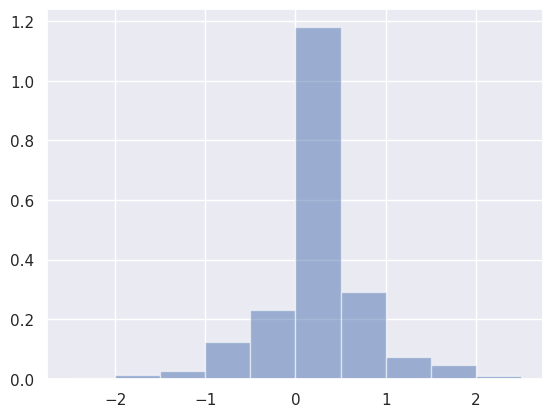

In [36]:
OB_quarter_second['mid_price'].diff().hist(density = True, alpha = 0.5)


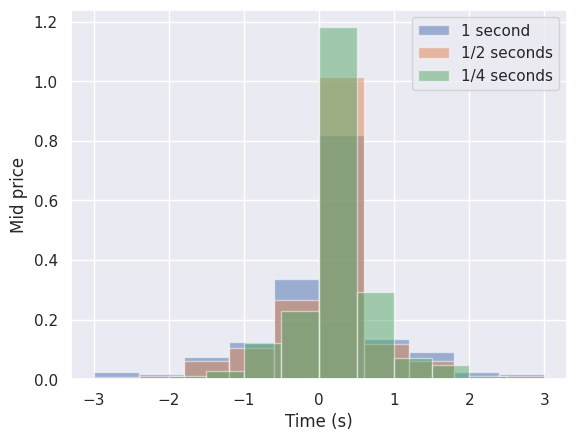

In [38]:
OB_second['mid_price'].diff().hist(density = True,alpha = 0.5)
OB_half_second['mid_price'].diff().hist(density = True,alpha = 0.5)
OB_quarter_second['mid_price'].diff().hist(density = True, alpha = 0.5)
plt.legend(['1 second','1/2 seconds','1/4 seconds'])
plt.xlabel('Time (s)')
plt.ylabel('Mid price')
plt.show()

The lower the sampling period, the more the mid-price variation is going to its mean, which makes sense because the price cannot move that much in very short periods of time.

### 2.5

In [39]:
num_autocorrs = 35

In [40]:
autocorrs = [mid_price.autocorr(lag = i) for i in range(num_autocorrs)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


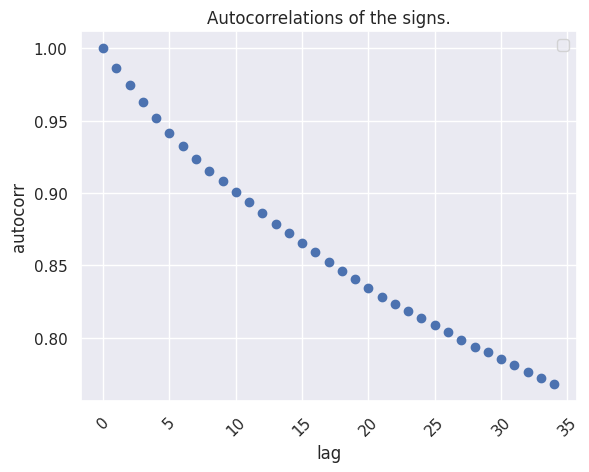

In [41]:
fig, ax = plt.subplots()
ax.scatter(list(range(num_autocorrs)), autocorrs, c = 'b')
ax.set_title('Autocorrelations of the signs.')
ax.set_ylabel('autocorr')
ax.set_xlabel('lag')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True)
ax.legend()

Auto-correlations are high, which can be the result of the trend in the mid-price we see on the plot of 2.3. 

### 2.6

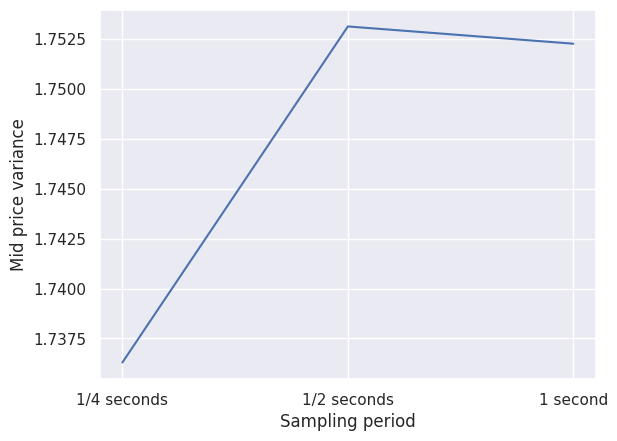

In [42]:
variance = np.array([OB_quarter_second['mid_price'].var(),OB_half_second['mid_price'].var(),OB_second['mid_price'].var()])
plt.plot(np.array(['1/4 seconds','1/2 seconds','1 second']),variance)
plt.xlabel('Sampling period')
plt.ylabel('Mid price variance')
plt.show()

We notice mid price variance decreases as we increase the sampling period which is what we expected, the smaller the sampling period the more the microvariations are taken into account.